# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.


## **Import The Necessary Libraries**



Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Function to print a box of asterisks (*) around a message.

def print_box(text, char='*'):
  msg = '*** {} ***'.format(text)
  msg_length = len(msg)
  print('')
  print(char * msg_length)
  print(msg)
  print(char * msg_length)

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


Next, let's install the Surprise library.

In [ ]:
!pip install surprise

print_box('Surprise installed!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163495 sha256=5594aab28159aeae510b5f0bf829d4d7684aa514db1c8967dbd83ee12f6e5fc8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise

***************************
*** Surprise installed! ***
***************************


Finally, let's install more libraries that we will need.

In [ ]:
import warnings                                 # Ignore warnings generated by deprecated functions, etc.
warnings.filterwarnings('ignore')

import numpy as np                              # Import Numpy
import pandas as pd                             # Import Pandas

import matplotlib.pyplot as plt                 # Import plotting library
import seaborn as sns                           # Import Seaborn for more plotting functionality

from collections import defaultdict             # Dictionary collection that can handle missing keys
from collections import Counter                 # Dictionary collection that counts keys

from sklearn.metrics import mean_squared_error  # Performance metric
print_box('Libraries imported!')


***************************
*** Libraries imported! ***
***************************


## **Import the Dataset**

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df_copy**

In [ ]:
# Import the dataset
df = pd.read_csv('ratings_Electronics.csv', header = None)  # Import the file - note file does not have any headers
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']  # Add column names
df = df.drop('timestamp', axis = 1)                         # Drop timestamp column since we don't need it
df_copy = df.copy(deep = True)                              # Make a copy of the data in case we mess up the original

# Output some information
rows, columns = df.shape
print('Shape of the data is:')
print('  {:,} rows'.format(rows))
print('  {} columns'.format(columns))
print('')
print('Dtypes in the dataframe: \n{}'.format(df.dtypes))
print('')
print('The first 5 rows are:')
df.head()

Shape of the data is:
  7,824,482 rows
  3 columns

Dtypes in the dataframe: 
user_id     object
prod_id     object
rating     float64
dtype: object

The first 5 rows are:


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

### **Trimming the Data**

#### Method 1: Original Method for Trimming the Data

In [ ]:
# Here in case we want to re-run with a fresh copy of the data
df = df_copy.copy(deep=True)

In [ ]:
# Step 1: Get a list of users and their number of ratings

# Get the column containing the users
users = df.user_id

# Create a dictionary of users and their number of ratings
user_ratings_count = dict()

# Loop through the list of users
for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in user_ratings_count:
        user_ratings_count[user] += 1

    # Otherwise, set their initial rating count to 1
    else:
        user_ratings_count[user] = 1

step_1_length = len(user_ratings_count)
print('There are {:,} unique users in the dataset.'.format(step_1_length))
print('')
print('The 5 users with the most ratings are:')
dict(Counter(user_ratings_count).most_common(5))   # Display the top 5 elements

There are 4,201,696 unique users in the dataset.

The 5 users with the most ratings are:


{'A5JLAU2ARJ0BO': 520,
 'ADLVFFE4VBT8': 501,
 'A3OXHLG6DIBRW8': 498,
 'A6FIAB28IS79': 431,
 'A680RUE1FDO8B': 406}

In [ ]:
# Step 2: Get list of users with less than 50 ratings and remove them

# We want our users to have at least 50 ratings to be considered
USER_RATINGS_CUTOFF = 50

# Initialize a new list to store users that we want to remove
remove_users = []

# Loop through the list of users
for user, num_ratings in user_ratings_count.items():
    if num_ratings < USER_RATINGS_CUTOFF:
        remove_users.append(user)

num_users_to_keep = len(user_ratings_count) - len(remove_users)
print('Number of users to keep = {:,}'.format(num_users_to_keep))

# Now remove the list of users from the main dataframe that have less than 50 ratings
df = df.loc[ ~ df.user_id.isin(remove_users)]
step_2_length = len(df)
print('After removing users, there are {:,} rows left.'.format(step_2_length))
print('')
print('First 5 rows are:')
df.head()

Number of users to keep = 1,540
After removing users, there are 125,871 rows left.

First 5 rows are:


,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [ ]:
# Step 3: Get list of products and the number of ratings

# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
prod_ratings_count = dict()

# Loop through the list of products
for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in prod_ratings_count:
        prod_ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        prod_ratings_count[prod] = 1

step_3_length = len(prod_ratings_count)
print('There are {:,} unique products in the dataset.'.format(step_3_length))
print('')
print('The 5 products with most ratings are:')
dict(Counter(prod_ratings_count).most_common(5)) # Display the top 5 elements

There are 48,190 unique products in the dataset.

The 5 products with most ratings are:


{'B0088CJT4U': 206,
 'B003ES5ZUU': 184,
 'B000N99BBC': 167,
 'B007WTAJTO': 164,
 'B00829TIEK': 149}

In [ ]:
# Step 4: Remove products with less than 5 ratings

# We want our item to have at least 5 ratings to be considered
PRODUCT_RATINGS_CUTOFF = 5

# Initialize a new list to store list of products
remove_products = []

# Loop through list of products
for user, num_ratings in prod_ratings_count.items():
    if num_ratings < PRODUCT_RATINGS_CUTOFF:
        remove_products.append(user)

num_prod_to_keep = len(prod_ratings_count) - len(remove_products)
print('Number of products to keep = {:,}'.format(num_prod_to_keep))

# Remove products that have less than 5 ratings
df_final = df.loc[~ df.prod_id.isin(remove_products)]

# Print a few rows of the final dataset
step_4_length = len(df_final)
print('After removing products, there are {:,} rows left.'.format(step_4_length))
print('')
print('First 5 rows are:')
df_final.head()

Number of products to keep = 5,689
After removing products, there are 65,290 rows left.

First 5 rows are:


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


#### Method 2: Another Method for Trimming the Data

This method uses the default dictionary collection to gather the necessary data.

In [ ]:
# Here in case with want to re-run with a fresh copy of the data
df_2 = df_copy.copy(deep=True)

In [ ]:
# Step 1: Count users and ratings using the default dictionary collection

# Get the column containing the users
users = df_2.user_id

# Create a default dictionary of users and their number of ratings
user_ratings_count_2 = defaultdict(int)

# Loop through users
for user in users:
  # Add user to dictionary; if it doesn't exist, add it; otherwise increment if it already exists
  user_ratings_count_2[user] += 1

# Validate this method against the original code
step_1_length_2 = len(user_ratings_count_2)
if step_1_length == step_1_length_2:
  print('Found {:,} unique users and it matches original code!'.format(step_1_length_2))
else:
  print('** Dataset has {:,} rows which does not match original code ({:,}). **'.format(step_1_length_2, step_1_length))
  continue_execution = False

# Output some rows
print('')
print('The 5 users with the most ratings are:')
dict(Counter(user_ratings_count_2).most_common(5)) # Display the top 5 elements

Found 4,201,696 unique users and it matches original code!

The 5 users with the most ratings are:


{'A5JLAU2ARJ0BO': 520,
 'ADLVFFE4VBT8': 501,
 'A3OXHLG6DIBRW8': 498,
 'A6FIAB28IS79': 431,
 'A680RUE1FDO8B': 406}

In [ ]:
# Verify that the 2 methods match by comparing the counts for a subset of user ids

# List of user ids to spot check
user_ids = ['A680RUE1FDO8B','A000063614T1OE0BUSKUT', 'A5JLAU2ARJ0BO', 'A3OXHLG6DIBRW8', 'A100UD67AHFODS']

# Loop through the list of user ids and get the counts from each of the methods
for user in user_ids:
  print('-' * 40)
  print('User id =', user)
  if user_ratings_count[user] == user_ratings_count_2[user]:
    print('  * Counts match with {:,} ratings.'.format(user_ratings_count_2[user]))
  else:
    print('  *** Count DO NOT MATCH: {:,} - {:,} ***'.format(user_ratings_count[user], user_ratings_count_2[user]))

----------------------------------------
User id = A680RUE1FDO8B
  * Counts match with 406 ratings.
----------------------------------------
User id = A000063614T1OE0BUSKUT
  * Counts match with 2 ratings.
----------------------------------------
User id = A5JLAU2ARJ0BO
  * Counts match with 520 ratings.
----------------------------------------
User id = A3OXHLG6DIBRW8
  * Counts match with 498 ratings.
----------------------------------------
User id = A100UD67AHFODS
  * Counts match with 116 ratings.


In [ ]:
# Step 2: Get list of users with less than 50 ratings and remove them

# Initialize a new list to store users that we want to remove
remove_users = []

# Loop through the list of users
for user, num_ratings in user_ratings_count_2.items():
    if num_ratings < USER_RATINGS_CUTOFF:
        remove_users.append(user)

num_users_to_keep_2 = len(user_ratings_count_2) - len(remove_users)

# Verify if the numbers match the original code
if num_users_to_keep == num_users_to_keep_2:
  print('Number of users to keep ({:,}) matches original code!'.format(num_users_to_keep_2))
else:
  print('*** Number of users to keep ({:,}) does not match original code ({:,})! ***'.format(num_users_to_keep_2, num_users_to_keep))

# Now remove the list of users from the main dataframe that have less than 50 ratings
df_2 = df_2.loc[ ~ df_2.user_id.isin(remove_users)]

# Verify if the length matches the original code
step_2_length_2 = len(df_2)
if step_2_length == step_2_length_2:
  print('After removing users, there are {:,} rows left and it matches original code!'.format(step_2_length_2))
else:
  print('*** After removing users, there are {:,} rows left and it does not match original code ({:,})! ***'.format(step_2_length_2, step_2_length))

# Output some stuff
print('')
print('First 5 rows are:')
df_2.head()

Number of users to keep (1,540) matches original code!
After removing users, there are 125,871 rows left and it matches original code!

First 5 rows are:


,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [ ]:
# Step 3: Another way to get list of products and the number of ratings
#         using the default dictionary collection

# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
prod_ratings_count_2 = defaultdict(int)

# Loop through the products list
for prod in prods:
    prod_ratings_count_2[prod] += 1

# Verify the length against the original code
step_3_length_2 = len(prod_ratings_count_2)
if step_3_length == step_3_length_2:
  print('There are {:,} unique products in the dataset and it matches original code.'.format(step_3_length_2))
else:
  print('** We found {:,} unique products and this does not match the original code ({:,}). **'.format(step_3_length_2, step_3_length))

# Output some rows
print('')
print('The 5 products with the most ratings are:')
print('')
dict(Counter(prod_ratings_count_2).most_common(5)) # Display the top 5 elements

There are 48,190 unique products in the dataset and it matches original code.

The 5 products with the most ratings are:



{'B0088CJT4U': 206,
 'B003ES5ZUU': 184,
 'B000N99BBC': 167,
 'B007WTAJTO': 164,
 'B00829TIEK': 149}

In [ ]:
# Verify that the 2 methods match by comparing the counts for a subset of product ids

# List of product ids to spot check
prod_ids = ['B0088CJT4U','B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829TIEK']

# Loop through the list of user ids and get the counts from each of the methods
for prod in prod_ids:
  print('-' * 40)
  print('Product id =', prod)
  if prod_ratings_count[prod] == prod_ratings_count_2[prod]:
    print('  * Counts match with {} ratings.'.format(prod_ratings_count_2[prod]))
  else:
    print('  *** Counts DO NOT MATCH: {} - {} ***'.format(prod_ratings_count[prod], prod_ratings_count_2[prod]))

----------------------------------------
Product id = B0088CJT4U
  * Counts match with 206 ratings.
----------------------------------------
Product id = B003ES5ZUU
  * Counts match with 184 ratings.
----------------------------------------
Product id = B000N99BBC
  * Counts match with 167 ratings.
----------------------------------------
Product id = B007WTAJTO
  * Counts match with 164 ratings.
----------------------------------------
Product id = B00829TIEK
  * Counts match with 149 ratings.


In [ ]:
# Step 4: Remove products with less than 5 ratings

# Initialize a new list to store list of products
remove_products = []

# Loop through list of products
for user, num_ratings in prod_ratings_count_2.items():
    if num_ratings < PRODUCT_RATINGS_CUTOFF:
        remove_products.append(user)

num_prod_to_keep_2 = len(prod_ratings_count_2) - len(remove_products)
if num_prod_to_keep == num_prod_to_keep_2:
  print('Number of products to keep ({:,}) matches original code!'.format(num_prod_to_keep_2))
else:
  print('*** Number of products to keep ({:,}) does not match original code ({:,})! ***'.format(num_prod_to_keep_2, num_prod_to_keep))

# Remove products that have less than 5 ratings
df_final_2 = df_2.loc[~ df_2.prod_id.isin(remove_products)]

# Print a few rows of the final dataset
step_4_length_2 = len(df_final_2)
if step_4_length == step_4_length_2:
  print('Final dataset has {:,} rows and it matches the original code!'.format(step_4_length_2))
else:
  print('*** Final dataset has {:,} rows and it does not match original code! ***'.format(step_4_length_2, step_4_length))

# Output some stuff
print('')
print('First 5 rows are:')
df_final_2.head()

Number of products to keep (5,689) matches original code!
Final dataset has 65,290 rows and it matches the original code!

First 5 rows are:


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


#### Method 3: And Yet Another Way to Trim the Data

Here is another way to trim the dataset using Pandas functions.

In [ ]:
# Create a copy of the original dataset
df_3 = df_copy.copy(deep=True)

In [ ]:
# Step 1: Get list of users and count the number of ratings

# Group by user_id and get size (not count) and set the column name to 'count'
user_ratings_count_3 = df_3.groupby('user_id').size().rename('count')

# Validate length against original code
step_1_length_3 = len(user_ratings_count_3)
if step_1_length == step_1_length_3:
  print('Dataset has {:,} rows and matches original results.'.format(step_1_length_3))
else:
  print('*** Dataset has {:,} rows which does not match original results ({,})! ***'.format(step_1_length_3, step_1_length))

# Output some stuff
print('')
print('Display the first 5 rows:')
user_ratings_count_3.head()

Dataset has 4,201,696 rows and matches original results.

Display the first 5 rows:


user_id
A00000262KYZUE4J55XGL    1
A000063614T1OE0BUSKUT    2
A00009182QVLSWIGHLS1B    1
A00009661LC9LQPGKJ24G    1
A00010809P09NUU6ZP6H     1
Name: count, dtype: int64

In [ ]:
# Verify that the 2 methods match by comparing the counts for a subset of user ids

# List of user ids to spot check
user_ids = ['A680RUE1FDO8B','A000063614T1OE0BUSKUT', 'A5JLAU2ARJ0BO', 'A3OXHLG6DIBRW8', 'A100UD67AHFODS']

# Loop through the list of user ids and get the counts from each of the methods
for user in user_ids:
  print('-' * 40)
  print('User id =', user)
  if user_ratings_count[user] == user_ratings_count_3[user]:
    print('  * Counts match with {:,} ratings.'.format(user_ratings_count_3[user]))
  else:
    print('  *** Count DO NOT MATCH: {:,} - {:,} ***'.format(user_ratings_count[user], user_ratings_count_3[user]))

----------------------------------------
User id = A680RUE1FDO8B
  * Counts match with 406 ratings.
----------------------------------------
User id = A000063614T1OE0BUSKUT
  * Counts match with 2 ratings.
----------------------------------------
User id = A5JLAU2ARJ0BO
  * Counts match with 520 ratings.
----------------------------------------
User id = A3OXHLG6DIBRW8
  * Counts match with 498 ratings.
----------------------------------------
User id = A100UD67AHFODS
  * Counts match with 116 ratings.


In [ ]:
# Step 2: Drop users from the list with less than 50 ratings

user_ratings_count_3.drop(user_ratings_count_3[user_ratings_count_3 < USER_RATINGS_CUTOFF].index, inplace=True)

# Verify the count against the original code
num_users_to_keep_3 = len(user_ratings_count_3)
if num_users_to_keep_3 == num_users_to_keep:
  print('Number of users to keep is {:,} and matches original results!'.format(num_users_to_keep_3))
else:
  print('** Number of users to keep is {:,} which does not match original results ({:,}). **'.format(num_users_to_keep_3, num_users_to_keep))

# Output some stuff
print('')
print('The 5 users with the most ratings are:')
user_ratings_count_3.sort_values(ascending=False).head()

Number of users to keep is 1,540 and matches original results!

The 5 users with the most ratings are:


user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: count, dtype: int64

In [ ]:
# Step 3: Keep all the users in the main dataframe that have 50 or more ratings

df_3 = df_3.loc[df_3.user_id.isin(user_ratings_count_3.index)]
step_2_length_3 = len(df_3)
if step_2_length_3 == step_2_length:
  print('Dataframe contains {:,} rows and matches original results!'.format(step_2_length_3))
else:
  print('** Dataframe contains {:,} rows which does not match original results ({:,})! **'.format(step_2_length_3, step_2_length))

print('')
print('Display the first 5 rows are:')
df_3.head()

Dataframe contains 125,871 rows and matches original results!

Display the first 5 rows are:


,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [ ]:
# Step 4: Get list of products and count the number of ratings

product_count_3 = df_3.groupby('prod_id').size().rename('count')  # Group by user_id and get size (not count) and set the column name to 'count'

# Verify length against original code
step_3_length_3 = len(product_count_3)
if step_3_length_3 == step_3_length:
  print('There are {:,} unique products and it matches the original results!'.format(step_3_length_3))
else:
  print('** There are {:,} unique products and this does not match the original results ({:,}). **'.format(step_3_length_3, step_3_length))

# Output some stuff
print('')
product_count_3.head()                                          # Display the first 5 rows

There are 48,190 unique products and it matches the original results!



prod_id
0594451647    1
0594481813    1
0970407998    2
0972683275    4
1400501466    6
Name: count, dtype: int64

In [ ]:
# Verify that the 2 methods match by comparing the counts for a subset of product ids

# List of product ids to spot check
prod_ids = ['B0088CJT4U','B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829TIEK']

# Loop through the list of user ids and get the counts from each of the methods
for prod in prod_ids:
  print('-' * 40)
  print('Product id =', prod)
  if prod_ratings_count[prod] == product_count_3[prod]:
    print('  * Counts match with {} ratings.'.format(product_count_3[prod]))
  else:
    print('  *** Counts DO NOT MATCH: {} - {} ***'.format(prod_ratings_count[prod], product_count_3[prod]))

----------------------------------------
Product id = B0088CJT4U
  * Counts match with 206 ratings.
----------------------------------------
Product id = B003ES5ZUU
  * Counts match with 184 ratings.
----------------------------------------
Product id = B000N99BBC
  * Counts match with 167 ratings.
----------------------------------------
Product id = B007WTAJTO
  * Counts match with 164 ratings.
----------------------------------------
Product id = B00829TIEK
  * Counts match with 149 ratings.


In [ ]:
# Step 5: Remove all products from the list that have less than 5 ratings

product_count_3.drop(product_count_3[product_count_3 < PRODUCT_RATINGS_CUTOFF].index, inplace=True)

# Verify count against original code
num_prod_to_keep_3 = len(product_count_3)
if num_prod_to_keep_3 == num_prod_to_keep:
  print('Number of products to keep is {:,} and it matches the original results!'.format(num_prod_to_keep_3))
else:
  print('** Number of products to keep is {:,} which does not match original results. **'.format(num_prod_to_keep_3))

# Output some stuff
print('')
print('Display the first 5 rows:')
product_count_3.head()

Number of products to keep is 5,689 and it matches the original results!

Display the first 5 rows:


prod_id
1400501466    6
1400532655    6
1400599997    5
9983891212    8
B00000DM9W    5
Name: count, dtype: int64

In [ ]:
# Step 6: Keep all the products with 5 or more ratings

df_final_3 = df_3.loc[df_3.prod_id.isin(product_count_3.index)]

# Verify the count against the original code
step_4_length_3 = len(df_final_3)
if step_4_length_3 == step_4_length:
  print('Dataframe contains {:,} rows and matches original results!'.format(step_4_length_3))
else:
  print('** Dataframe contains {:,} rows which does not match original results. **'.format(step_4_length_3))

# Output some stuff
print('')
print('First 5 rows are:')
df_final_3.head()

Dataframe contains 65,290 rows and matches original results!

First 5 rows are:


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print('Number of rows = {:,}'.format(rows))
print('Number of columns = {:,}'.format(columns))

Number of rows = 65,290
Number of columns = 3


**Write your observations here:**

1. The final dataframe contains 65,290 rows.
2. This is way less than the original 7.8 million rows.
3. The final dataframe still contains the same number of columns.



### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:**

1. The user_id and prod_id columns are object types.
2. The rating column is a float64 type.  This means we can compute things like the average ratings, standard deviation, etc.


### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [ ]:
df_final['rating'].value_counts()

5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64

**Write your observations here:**

There are no missing values in the dataframe.

The lowest rating is 1. This means that there are no ratings of zero which might indicate products with no ratings.

The ratings are all whole numbers.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Write your observations here:**

1. The average of all ratings is 4.2948.
2. The standard deviation is 0.99 or we can round it to 1.
3. There are 65,290 ratings or rows in the dataset.
4. The minimum rating is 1 and the maximum is 5.
5. There are no products with a rating of zero.  This most likely indicates that all products have a valid rating.



### **Checking the rating distribution**

In [ ]:
df_final['rating'].value_counts(normalize=True)

5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: rating, dtype: float64

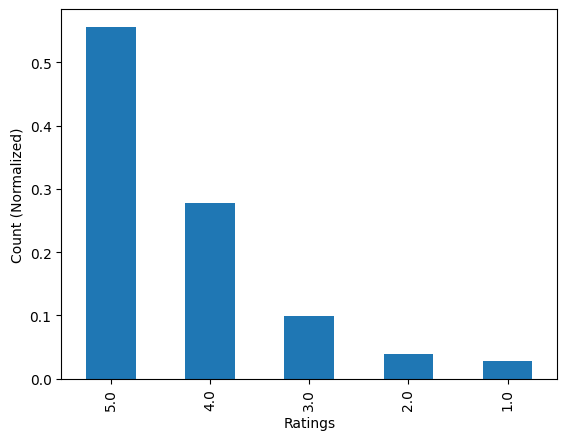

In [ ]:
# Create the bar plot and provide observations

df_final['rating'].value_counts(normalize=True).plot(kind = 'bar')
plt.ylabel('Count (Normalized)')
plt.xlabel('Ratings')
plt.show()

**Write your observations here:**

1. Approximately 56% of the ratings are 5.0
2. Approximately 28% of the ratings are 4.0.
3. 83% of the ratings are either 4 or 5.
3. Counts decrease with ratings.  Meaning count for 5 > count for 4 > count for 3 > count for 2 > count for 1.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

total_recommendations = len(df_final)
unique_users = df_final['user_id'].nunique()
unique_products = df_final['prod_id'].nunique()
max_combinations = unique_users * unique_products
percentage_ratings = total_recommendations / max_combinations

print('The number of rows in the final dataset = {:,}'.format(total_recommendations))
print('The number of unique users in the final dataset = {:,}'.format(unique_users))
print('The number of unique products in the final dataset = {:,}'.format(unique_products))
print('Maximum possible combination of ratings = {:,}'.format(max_combinations))
print('Percentage of max recommendations = {:2.2%}'.format(percentage_ratings))

The number of rows in the final dataset = 65,290
The number of unique users in the final dataset = 1,540
The number of unique products in the final dataset = 5,689
Maximum possible combination of ratings = 8,761,060
Percentage of max recommendations = 0.75%


**Write your observations here:**

1. There are a total of 65,290 rows in the final dataset.
2. There are a total of 1,540 unique user ids.
3. There are a total of 5,689 unique product ids.

If each user rated all products, there would be a total of 8.7 million ratings.  Since we only have 65,290 rows in our dataset, this represents less than 1% of the maximum number of recommendations.  This means there are plenty of opportunities to recommend products to all users.


### **Users with the most number of ratings**



In [ ]:
# Top 10 users based on the number of ratings
df_top = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
df_top

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

In [ ]:
top_user = df_top.index[0]
total_products_rated = df_top[0]
print('Percent of products rated by user {} is {:2.2%}.'.format(top_user, total_products_rated/unique_products))

Percent of products rated by user ADLVFFE4VBT8 is 5.19%.


**Write your observations here:**

The user with the most number of ratings only rated 295 products out of 5,689.  This represents a little over 5% of all available products.  This means that there are many more products that we can recommend to this user as well as others.


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating' : avg_rating, 'rating_count' : count_rating })

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

  # Finding products with minimum number of interactions
  recommendations = final_rating[final_rating['rating_count'] > min_interaction]

  # Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

  return recommendations.index[:n]

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
retVal = top_n_products(final_rating, 5, 50)
retVal.values.tolist()

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
retVal = top_n_products(final_rating, 5, 100)
retVal.values.tolist()

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

print_box('Libraries imported!')


***************************
*** Libraries imported! ***
***************************


**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    return {
        'RMSE': accuracy.rmse(predictions, verbose=False),
        'precision': precision,
        'recall': recall,
        'f1_score': (2*precision*recall)/(precision+recall)
    }

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


In [ ]:
def print_model_scores(scores):
  print('RMSE: {:.4f}'.format(scores['RMSE']))            # Print the RMSE score
  print('Precision: {:.3f}'.format(scores['precision']))  # Print the overall precision
  print('Recall: {:.3f}'.format(scores['recall']))        # Print the overall recall
  print('F_1 score: {:.3f}'.format(scores['f1_score']))   # Print the F1 score

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
df_test = df_final.copy()
df_test.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
df_test['rating_2'] = df_test['rating'] - 1
df_test.head()

,user_id,prod_id,rating,rating_2
1310,A3LDPF5FMB782Z,1400501466,5.0,4.0
1322,A1A5KUIIIHFF4U,1400501466,1.0,0.0
1335,A2XIOXRRYX0KZY,1400501466,3.0,2.0
1451,AW3LX47IHPFRL,1400501466,5.0,4.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0,0.0


In [ ]:
df_test[['user_id', 'prod_id', 'rating_2']]

,user_id,prod_id,rating_2
1310,A3LDPF5FMB782Z,1400501466,4.0
1322,A1A5KUIIIHFF4U,1400501466,0.0
1335,A2XIOXRRYX0KZY,1400501466,2.0
1451,AW3LX47IHPFRL,1400501466,4.0
1456,A1E3OB6QMBKRYZ,1400501466,0.0
...,...,...,...
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,4.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,4.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,4.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,4.0


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
# Seed the random generator with 42 so that the sets are consistent across multiple calls.
# 42 is a common value to use in data science
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

print_box('Done!')


*************
*** Done! ***
*************


In [ ]:
avg_rating = df_final.groupby('prod_id').mean()['rating']
avg_rating.sort_values()

prod_id
B000UF3FT8    1.375000
B004OBUFYW    1.400000
B007C0Y7RI    1.625000
B000ND75C0    1.833333
B003O2RVGM    1.833333
                ...   
B007SZ0EHE    5.000000
B001FN14RE    5.000000
B007SZ0EOW    5.000000
B00DKBU5W4    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64

In [ ]:
prod_2 = avg_rating.sort_values().index[0]
prod_2_avg = avg_rating.sort_values()[0]
print('The average rating for {} is {}.'.format(prod_2, prod_2_avg))

The average rating for B000UF3FT8 is 1.375.


In [ ]:
df_final.loc[df['prod_id'] == 'B000UF3FT8']

,user_id,prod_id,rating
1393642,ADLVFFE4VBT8,B000UF3FT8,1.0
1393651,A3TNM3C9ENUCFW,B000UF3FT8,1.0
1393682,A377LPVLLAI42D,B000UF3FT8,1.0
1393699,A23GFTVIETX7DS,B000UF3FT8,4.0
1393700,A2UOHALGF2X77Q,B000UF3FT8,1.0
1393708,A3SMD3T0QTN109,B000UF3FT8,1.0
1393728,AM3XNQU9TZBD8,B000UF3FT8,1.0
1393796,A31BD4RXCON7QO,B000UF3FT8,1.0


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
similarity_options = {'name': 'cosine',
                      'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
similarity_user_user = KNNBasic(sim_options=similarity_options, verbose=False)

# Fit the model on the training data
similarity_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
similarity_user_user_scores = precision_recall_at_k(similarity_user_user)
print_model_scores(similarity_user_user_scores)

RMSE: 1.0012
Precision: 0.855
Recall: 0.858
F_1 score: 0.856


**Write your observations here:**

* RMSE is 1.0012.
* Precision is 0.855.  This means that 85.5% of the recommendations are relevant to the user.  
* Recall is 0.858.  This means that 85.8% of the relevant products were recommended to the user.

While both precision and recall are not perfect, they are pretty high.  This model will do a good job picking products (recall) that the user will like (precision).

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_1 = 'A3LDPF5FMB782Z'
prod_1 = '1400501466'
prediction_1 = similarity_user_user.predict(user_1, prod_1, r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


In [ ]:
# List ratings for this product

df_final.loc[df['prod_id'] == prod_1]

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
1485,A19N3S7CBSU6O7,1400501466,5.0


In [ ]:
# Output some statistics for product 1400501466.

df_final.loc[df['prod_id'] == prod_1]['rating'].describe()

count    6.000000
mean     3.333333
std      1.966384
min      1.000000
25%      1.500000
50%      4.000000
75%      5.000000
max      5.000000
Name: rating, dtype: float64

In [ ]:
prod_1_avg = avg_rating[prod_1]
print('The average rating for {} is {}.'.format(prod_1, prod_1_avg))

The average rating for 1400501466 is 3.3333333333333335.


In [ ]:
# Function to extract the estimate from the prediction string
def extract_estimate(prediction):
  text = str(prediction)
  left = 'est ='
  right = '{'
  return float(str(text[text.index(left)+len(left):text.index(right)]).strip())

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


**Write your observations here:**

There were 6 ratings for this product in the dataset, ranging from 1 to 5 with a mean of 3.33.  The algorithm predicted a rating of 3.4 for this user.  It was not close to the user's actual rating of 5.  It's much closer to the mean rating for this product.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, prod_1)

['A3HCMJOGRRSAF2',
 'A2LLSFQO8O8XNW',
 'AEIB3UR05OP7A',
 'AHS6PX6H22WW1',
 'A1R19YYR5OR26T']

In [ ]:
n_users_not_interacted_with(5, df_final, prod_2)

['A3HCMJOGRRSAF2',
 'A2LLSFQO8O8XNW',
 'AEIB3UR05OP7A',
 'AHS6PX6H22WW1',
 'A1R19YYR5OR26T']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_2 = 'A2UOHALGF2X77Q'
prediction_2 = similarity_user_user.predict(user_2, prod_1, verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


**Write your observations here:**

Based on similar products that this user and others have rated, the model predicts that this user will give a rating of 5.

In [ ]:
user_3 = 'ADLVFFE4VBT8'
prediction_3 = similarity_user_user.predict(user_3, prod_2, verbose = True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 1.51   {'actual_k': 6, 'was_impossible': False}


In [ ]:
user_4 = 'AEIB3UR05OP7A'
prediction_4 = similarity_user_user.predict(user_4, prod_2, verbose = True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


In [ ]:
# Add model name and the 2 predictions
similarity_user_user_scores = {**{'model': 'User-user Collaborative Filtering'},
                               **similarity_user_user_scores,
                               **{user_1: extract_estimate(prediction_1),
                                  user_2: extract_estimate(prediction_2),
                                  user_3: extract_estimate(prediction_3),
                                  user_4: extract_estimate(prediction_4)
                                 }}
similarity_user_user_scores

{'model': 'User-user Collaborative Filtering',
 'RMSE': 1.0011755412614134,
 'precision': 0.855,
 'recall': 0.858,
 'f1_score': 0.8564973730297722,
 'A3LDPF5FMB782Z': 3.4,
 'A2UOHALGF2X77Q': 5.0,
 'ADLVFFE4VBT8': 1.51,
 'AEIB3UR05OP7A': 4.0}

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [40,50,60,70],
              'min_k': [1,3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
             }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print('Best RMSE score = {:.3f}'.format(gs.best_score['rmse']))

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score = 0.972
Best parameters: {'k': 70, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
similarity_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_user_user_optimized = KNNBasic(sim_options = similarity_options, k = 60, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
similarity_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
similarity_user_user_optimized_scores = precision_recall_at_k(similarity_user_user_optimized)
print_model_scores(similarity_user_user_optimized_scores)

RMSE: 0.9526
Precision: 0.847
Recall: 0.894
F_1 score: 0.870


**Write your observations here:**

The RMSE score is better than the untuned model (0.9526 vs. 1.0012), but only slightly better than what GridSearchCV returned (0.9526 vs. 0.972).  The precision is slightly worse than the untuned model (0.847 vs. 0.855).  But recall is slightly better (0.894 vs. 0.858).

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction_1 = similarity_user_user_optimized.predict(user_1, '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
prediction_2 = similarity_user_user_optimized.predict(user_2, '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
prediction_3 = similarity_user_user_optimized.predict(user_3, prod_2, verbose=True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 1.51   {'actual_k': 6, 'was_impossible': False}


In [ ]:
prediction_4 = similarity_user_user_optimized.predict(user_4, prod_2, verbose=True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
print('The global mean of the training set is {:.2f}'.format(trainset.global_mean))

The global mean of the training set is 4.29


**Write your observations here:**

For both users, the model returned a reason of "Not enough neighbors."  Because of this, the model returned a default estimated rating of 4.29, which is the global mean of the training set.

This is interesting since the first user, A3LDPF5FMB782Z, actually rated this product.

In [ ]:
# Add model name and the 2 predictions
similarity_user_user_optimized_scores = {**{'model': 'Optimized User-user Collaborative Filtering'},
                                         **similarity_user_user_optimized_scores,
                                         **{user_1: extract_estimate(prediction_1),
                                            user_2: extract_estimate(prediction_2),
                                            user_3: extract_estimate(prediction_3),
                                            user_4: extract_estimate(prediction_4)
                                           }}
similarity_user_user_optimized_scores

{'model': 'Optimized User-user Collaborative Filtering',
 'RMSE': 0.9526006050262393,
 'precision': 0.847,
 'recall': 0.894,
 'f1_score': 0.8698655944859275,
 'A3LDPF5FMB782Z': 4.29,
 'A2UOHALGF2X77Q': 4.29,
 'ADLVFFE4VBT8': 1.51,
 'AEIB3UR05OP7A': 4.29}

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
similarity_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_user_user_optimized)
top_5_recommendations

[('B000067RT6', 5),
 ('B000BQ7GW8', 5),
 ('B001TH7GUU', 5),
 ('B005ES0YYA', 5),
 ('B00834SJSK', 5)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(top_5_recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
similarity_options = {'name': 'cosine',
                      'user_based': False}

# KNN algorithm is used to find desired similar items
similarity_item_item = KNNBasic(sim_options = similarity_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
similarity_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
similarity_item_item_scores = precision_recall_at_k(similarity_item_item)
print_model_scores(similarity_item_item_scores)

RMSE: 0.9950
Precision: 0.838
Recall: 0.845
F_1 score: 0.841


**Write your observations here:**

The RMSE is slightly worse than the optimized user-user model (0.995 vs. 0.9526).  Precision and recall are both slightly worse as well.

Even though the numbers are slightly worse than the optimized user-user model, it's not by much.  This model can still be used to recommend products as well as predict a user's ratings.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
prediction_1 = similarity_item_item.predict(user_1, '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


**Write your observations here:**

This model predicted a rating of 4.27 for this user/product combination.  This was much closer to the user's actual rating of 5 compared to the previous rating of 3.4 for the untuned user-user model.

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
prediction_2 = similarity_item_item.predict(user_2, '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


In [ ]:
prediction_3 = similarity_item_item.predict(user_3, prod_2, verbose=True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 4.25   {'actual_k': 40, 'was_impossible': False}


In [ ]:
prediction_4 = similarity_item_item.predict(user_4, prod_2, verbose=True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


**Write your observations here:**

This model gave a prediction of 4.0, which is different compared to the 5.0 rating that the untuned user-user model predicted.

In [ ]:
# Add model name and the 2 predictions
similarity_item_item_scores = {**{'model': 'Item-item Collaborative Filtering'},
                               **similarity_item_item_scores,
                               **{user_1: extract_estimate(prediction_1),
                                  user_2: extract_estimate(prediction_2),
                                  user_3: extract_estimate(prediction_3),
                                  user_4: extract_estimate(prediction_4)
                                 }}
similarity_item_item_scores

{'model': 'Item-item Collaborative Filtering',
 'RMSE': 0.9950233537893638,
 'precision': 0.838,
 'recall': 0.845,
 'f1_score': 0.8414854426619133,
 'A3LDPF5FMB782Z': 4.27,
 'A2UOHALGF2X77Q': 4.0,
 'ADLVFFE4VBT8': 4.25,
 'AEIB3UR05OP7A': 5.0}

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
parameter_grid = {'k': [10,20,30],
                  'min_k': [3,6,9],
                  'sim_options': {'name': ['msd', 'cosine'],
                                  'user_based': [False]}
                 }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid=parameter_grid, measures=['rmse'], cv=3)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print('Best RMSE score = {:.3f}'.format(gs.best_score['rmse']))

# Find the combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
similarity_options = {'name': 'msd',
                      'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_item_item_optimized = KNNBasic(sim_options=similarity_options , k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
similarity_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
similarity_item_item_optimized_scores = precision_recall_at_k(similarity_item_item_optimized)
print_model_scores(similarity_item_item_optimized_scores)

RMSE: 0.9576
Precision: 0.839
Recall: 0.880
F_1 score: 0.859


**Write your observations here:**

After optimizing the model, the RMSE dropped slightly from 0.995 to 0.9576.  Precision pretty much stayed the same (0.839 vs. 0.838) while recall went up from 0.845 to 0.88.

Overall, based on the scores, I expect this model to perform better than the previous models since the RMSE score went down.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction_1 = similarity_item_item_optimized.predict(user_1, '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.67   {'actual_k': 22, 'was_impossible': False}


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
prediction_2 = similarity_item_item_optimized.predict(user_2, '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
prediction_3 = similarity_item_item_optimized.predict(user_3, prod_2, verbose=True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 1.95   {'actual_k': 30, 'was_impossible': False}


In [ ]:
prediction_4 = similarity_item_item_optimized.predict(user_4, prod_2, verbose=True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Write your observations here:**

For user A3LDPF5FMB782Z, the tuned model predicted a rating of 4.71, which is much closer to the user's original rating of 5.0 compared to all the other models so far.

For the other user, A2UOHALGF2X77Q, the model was not able to estimate a rating because it did not find enough neighbors.  Instead, it gave a default rating of 4.29, which is the global mean of the training dataset.

In [ ]:
# Add model name and the 2 predictions
similarity_item_item_optimized_scores = {**{'model': 'Optimized Item-item Collaborative Filtering'},
                                         **similarity_item_item_optimized_scores,
                                         **{user_1: extract_estimate(prediction_1),
                                            user_2: extract_estimate(prediction_2),
                                            user_3: extract_estimate(prediction_3),
                                            user_4: extract_estimate(prediction_4)
                                           }}
similarity_item_item_optimized_scores

{'model': 'Optimized Item-item Collaborative Filtering',
 'RMSE': 0.9575820357589861,
 'precision': 0.839,
 'recall': 0.88,
 'f1_score': 0.8590110529377546,
 'A3LDPF5FMB782Z': 4.67,
 'A2UOHALGF2X77Q': 4.29,
 'ADLVFFE4VBT8': 1.95,
 'AEIB3UR05OP7A': 4.29}

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similarity_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, similarity_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(top_5_recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [ ]:
print('The global mean of the training set is {:.6f}'.format(trainset.global_mean))

The global mean of the training set is 4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_scores = precision_recall_at_k(svd)
print_model_scores(svd_scores)

RMSE: 0.8882
Precision: 0.853
Recall: 0.880
F_1 score: 0.866


**Write your observations here:**

The RMSE of 0.8882 is the lowest of all the models so far.  The precision and recall are not the best, but close to the top.

This model should perform well.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
prediction_1 = svd.predict(user_1, '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


**Write your observations here:**

This model predicted a rating of 4.08, which is worse than the tuned item-item model.

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
prediction_2 = svd.predict(user_2, '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.16   {'was_impossible': False}


In [ ]:
prediction_3 = svd.predict(user_3, prod_2, verbose = True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 2.50   {'was_impossible': False}


In [ ]:
prediction_4 = svd.predict(user_4, prod_2, verbose = True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 3.61   {'was_impossible': False}


**Write your observations here:**

This model was able to estimate a rating of 4.16 for this user/product combination.

In [ ]:
# Add model name and the 2 predictions
svd_scores = {**{'model': 'SVD'},
              **svd_scores,
              **{user_1: extract_estimate(prediction_1),
                 user_2: extract_estimate(prediction_2),
                 user_3: extract_estimate(prediction_3),
                 user_4: extract_estimate(prediction_4)
                }}
svd_scores

{'model': 'SVD',
 'RMSE': 0.8882171878209765,
 'precision': 0.853,
 'recall': 0.88,
 'f1_score': 0.8662896710905943,
 'A3LDPF5FMB782Z': 4.08,
 'A2UOHALGF2X77Q': 4.16,
 'ADLVFFE4VBT8': 2.5,
 'AEIB3UR05OP7A': 3.61}

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
parameter_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
    }

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid=parameter_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print('Best RMSE score = {:.3f}'.format(gs.best_score['rmse']))

# Combination of parameters that gave the best RMSE score
print('Best parameters: ', gs.best_params['rmse'])

Best RMSE score = 0.897
Best parameters:  {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the train set
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_optimized_scores = precision_recall_at_k(svd_optimized)
print_model_scores(svd_optimized_scores)

RMSE: 0.8808
Precision: 0.854
Recall: 0.878
F_1 score: 0.866


**Write your observations here:**

The RMSE value for this model is the best among all the models that we have tested.  The precision is very close to the top and the recall value is also one of the better ones.

Overall, this model will perform well.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction_1 = svd_optimized.predict(user_1, '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
prediction_2 = svd_optimized.predict(user_2, '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


In [ ]:
prediction_3 = svd_optimized.predict(user_3, prod_2, verbose=True)

user: ADLVFFE4VBT8 item: B000UF3FT8 r_ui = None   est = 2.54   {'was_impossible': False}


In [ ]:
prediction_4 = svd_optimized.predict(user_4, prod_2, verbose=True)

user: AEIB3UR05OP7A item: B000UF3FT8 r_ui = None   est = 3.05   {'was_impossible': False}


**Write your observations here:**

For user A3LDPF5FMB782Z, it estimated a rating for 4.13.  This is not close to the user's actual rating of 5.0.

For the other user, A2UOHALGF2X77Q, it was able to find a comparable neighbor and estimated a rating of 4.11.

In [ ]:
# Add model name and the 2 predictions
svd_optimized_scores = {**{'model': 'SVD Optimized'},
                        **svd_optimized_scores,
                        **{user_1: extract_estimate(prediction_1),
                           user_2: extract_estimate(prediction_2),
                           user_3: extract_estimate(prediction_3),
                           user_4: extract_estimate(prediction_4)
                          }}
svd_optimized_scores

{'model': 'SVD Optimized',
 'RMSE': 0.8808361571287852,
 'precision': 0.854,
 'recall': 0.878,
 'f1_score': 0.8658337182448037,
 'A3LDPF5FMB782Z': 4.13,
 'A2UOHALGF2X77Q': 4.11,
 'ADLVFFE4VBT8': 2.54,
 'AEIB3UR05OP7A': 3.05}

## **Comparing the Models**

Let's compare the scores for all the models.  For each metric, let's plot them in rank order from left (best) to right (worst).

In [ ]:
df_model_scores = pd.DataFrame(np.array([list(similarity_user_user_scores.values()),
                                         list(similarity_user_user_optimized_scores.values()),
                                         list(similarity_item_item_scores.values()),
                                         list(similarity_item_item_optimized_scores.values()),
                                         list(svd_scores.values()),
                                         list(svd_optimized_scores.values())
                                         ]),
                               columns=list(similarity_item_item_scores.keys()))
df_model_scores = df_model_scores.astype({'RMSE': 'float',
                                          'precision': 'float',
                                          'recall': 'float',
                                          'f1_score': 'float',
                                          'A3LDPF5FMB782Z': 'float',
                                          'A2UOHALGF2X77Q': 'float',
                                          user_3: 'float',
                                          user_4: 'float'
                                         })
df_model_scores

,model,RMSE,precision,recall,f1_score,A3LDPF5FMB782Z,A2UOHALGF2X77Q,ADLVFFE4VBT8,AEIB3UR05OP7A
0,User-user Collaborative Filtering,1.001176,0.855,0.858,0.856497,3.40,5.00,1.51,4.00
1,Optimized User-user Collaborative Filtering,0.952601,0.847,0.894,0.869866,4.29,4.29,1.51,4.29
2,Item-item Collaborative Filtering,0.995023,0.838,0.845,0.841485,4.27,4.00,4.25,5.00
3,Optimized Item-item Collaborative Filtering,0.957582,0.839,0.880,0.859011,4.67,4.29,1.95,4.29
4,SVD,0.888217,0.853,0.880,0.866290,4.08,4.16,2.50,3.61
5,SVD Optimized,0.880836,0.854,0.878,0.865834,4.13,4.11,2.54,3.05


In [ ]:
df_model_scores.describe()

,RMSE,precision,recall,f1_score,A3LDPF5FMB782Z,A2UOHALGF2X77Q,ADLVFFE4VBT8,AEIB3UR05OP7A
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.945906,0.847667,0.872500,0.859830,4.140000,4.308333,2.376667,4.040000
std,0.051401,0.007633,0.017729,0.010264,0.417516,0.356506,1.023282,0.665312
min,0.880836,0.838000,0.845000,0.841485,3.400000,4.000000,1.510000,3.050000
25%,0.904313,0.841000,0.863000,0.857126,4.092500,4.122500,1.620000,3.707500
50%,0.955091,0.850000,0.879000,0.862422,4.200000,4.225000,2.225000,4.145000
75%,0.985663,0.853750,0.880000,0.866176,4.285000,4.290000,2.530000,4.290000
max,1.001176,0.855000,0.894000,0.869866,4.670000,5.000000,4.250000,5.000000


In [ ]:
hline = (1, 'hello')
print(hline[0])
print(hline[1])

1
hello


In [ ]:
def plot_scores(df_scores, title, column, ylabel='', ascending=False, hline=(-1, '')):

  # Sort the dataframe in ascending or descending order
  df_sorted = df_scores.sort_values(by=column, ascending=ascending)

  # Setup the plot
  plt.title(title, fontsize=20)                                     # Set the plot title
  sns.set_style('whitegrid')                                        # Set the grid style

  # Plot the data
  ax = sns.barplot(data=df_sorted, x='model', y=column);

  # Add some finishing touches to the plot

  # Add horizontal lines if specified
  if hline[0] > 0:                                                  # Did caller specify a horizontal line?
    ax.axhline(y = hline[0])                                        # Yes, add a horizontal line at specified location
    x_pt = len(df_scores) - 0.25                                    # Figure out where to align the text
    temp = '{} ({:.3f})'.format(hline[1], hline[0])                 # Build text string
    ax.text(x_pt, hline[0], temp)                                   # Print the text on the graph
    ax.axhline(y = trainset.global_mean)                            # Include the global mean
    temp = 'Global Mean ({:.3f})'.format(trainset.global_mean)      # Format the string
    ax.text(x_pt, trainset.global_mean, temp)                       # Print the text on the graph

  # Adjust the x axis tick labels
  ax.set_xticklabels(ax.get_xticklabels(),
                     rotation=45,
                     horizontalalignment='right')
  ax.bar_label(ax.containers[0], fmt='%.3f')

  # Add the X and Y Axis labels
  plt.xlabel('Model', fontsize=16)
  if len(ylabel) == 0:
    ylabel=column
  plt.ylabel(ylabel, fontsize=16)

  # Finally, output all the changes
  plt.show()

print_box('Function loaded!')


************************
*** Function loaded! ***
************************


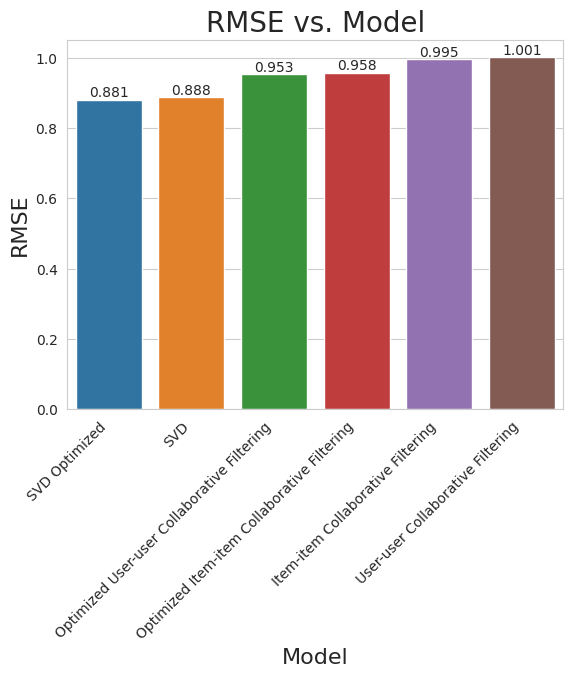

In [ ]:
plot_scores(df_model_scores, 'RMSE vs. Model', 'RMSE', ascending=True)

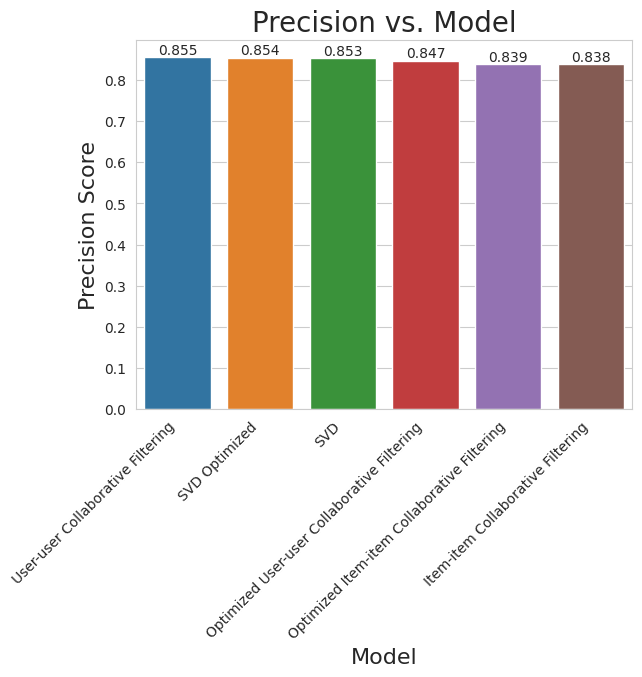

In [ ]:
plot_scores(df_model_scores, 'Precision vs. Model', 'precision', 'Precision Score')

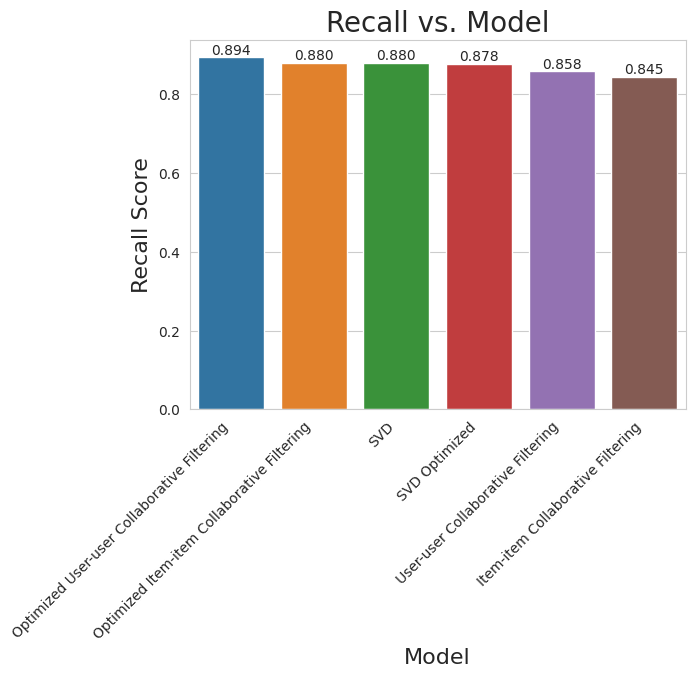

In [ ]:
plot_scores(df_model_scores, 'Recall vs. Model', 'recall', 'Recall Score')

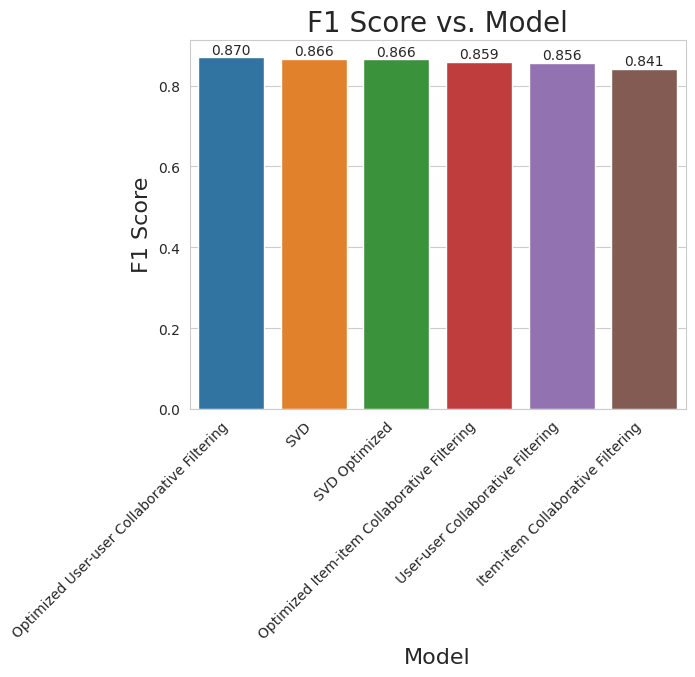

In [ ]:
plot_scores(df_model_scores, 'F1 Score vs. Model', 'f1_score', 'F1 Score')

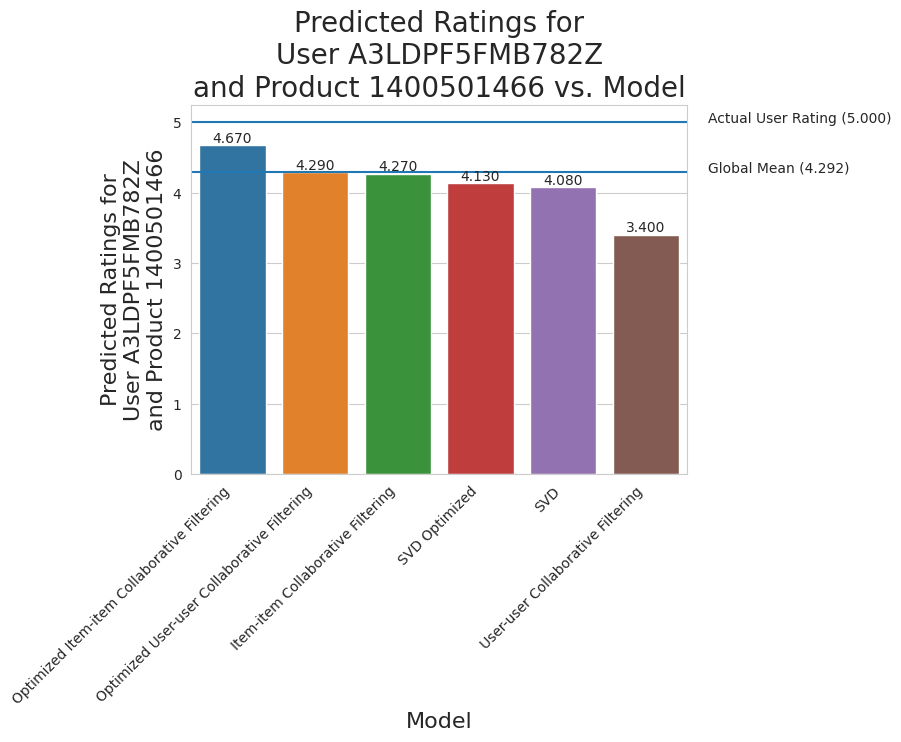

In [ ]:
ylabel = 'Predicted Ratings for\nUser {}\nand Product {}'.format(user_1, prod_1)
title = '{} vs. Model'.format(ylabel)
plot_scores(df_model_scores, title, user_1, ylabel, hline=(5.0, 'Actual User Rating'))

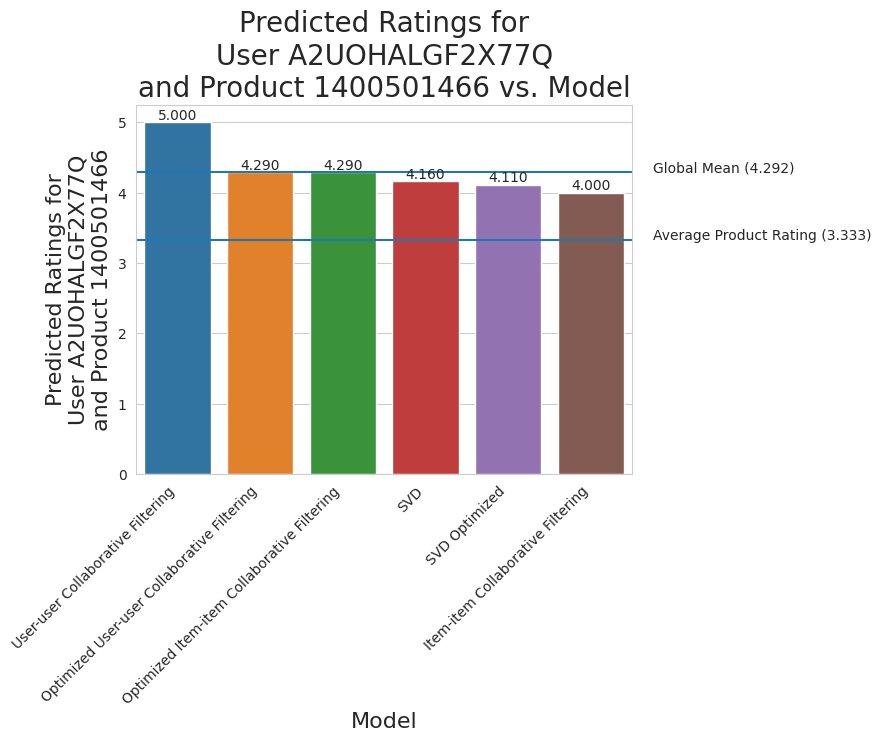

In [ ]:
ylabel = 'Predicted Ratings for\nUser {}\nand Product {}'.format(user_2, prod_1)
title = '{} vs. Model'.format(ylabel)
plot_scores(df_model_scores, title, user_2, ylabel, hline=(prod_1_avg, 'Average Product Rating'))

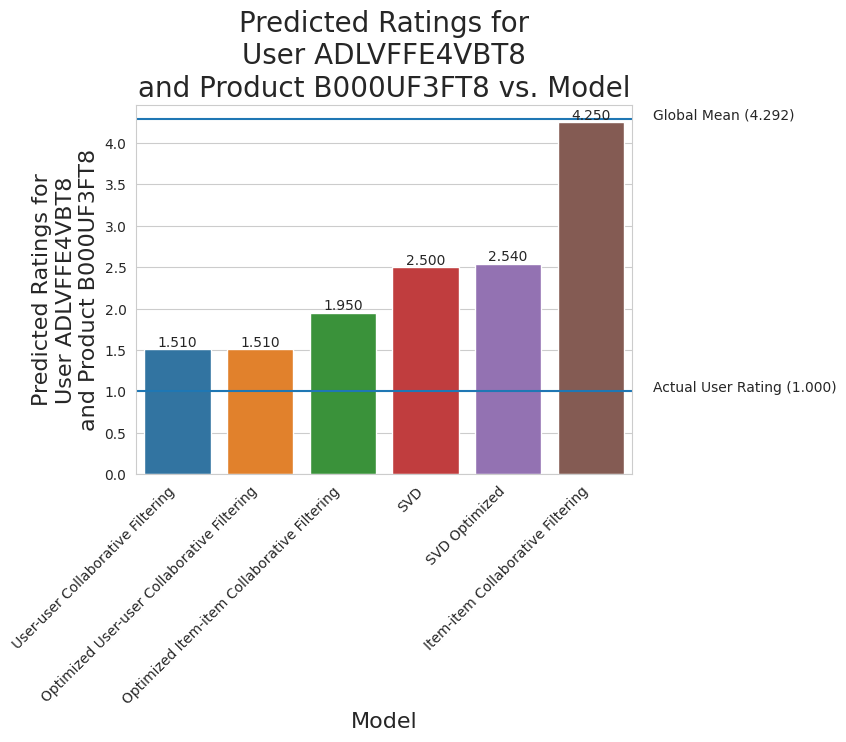

In [ ]:
ylabel = 'Predicted Ratings for\nUser {}\nand Product {}'.format(user_3, prod_2)
title = '{} vs. Model'.format(ylabel)
plot_scores(df_model_scores, title, user_3, ylabel, True, hline=(1.0, 'Actual User Rating'))

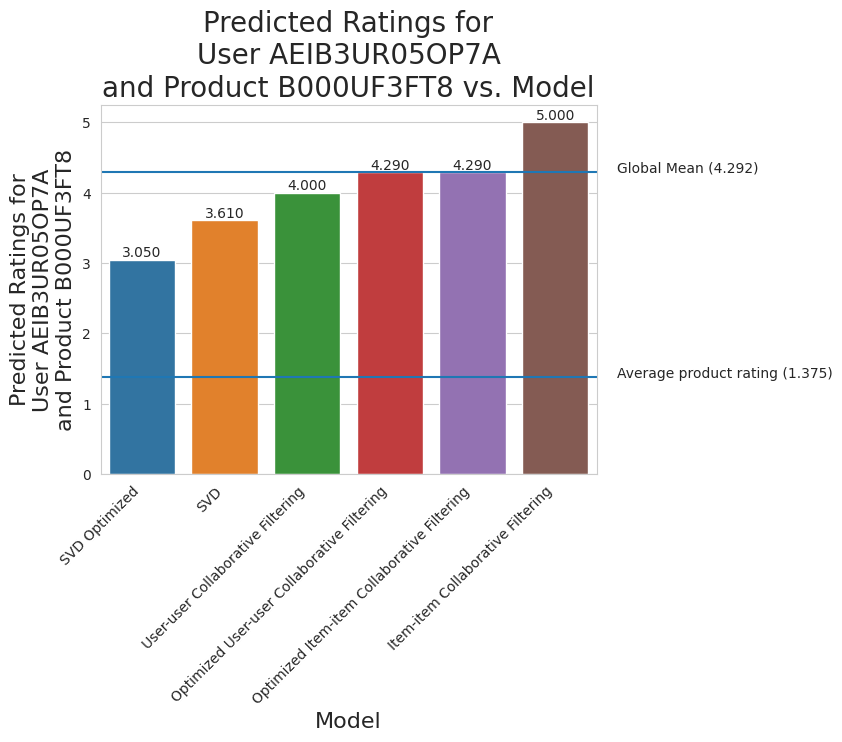

In [ ]:
ylabel = 'Predicted Ratings for\nUser {}\nand Product {}'.format(user_4, prod_2)
title = '{} vs. Model'.format(ylabel)
plot_scores(df_model_scores, title, user_4, ylabel, True, hline=(prod_2_avg, 'Average product rating'))

## **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

The Rank-based recommendation system will not do a good job in finding products to recommend.  It will always return the same set of products regardless of the user since it is based on the average rating.  Also, if a product has a high average rating but low number of ratings, the rating may not be as reliable as another product with a high average and larger number of ratings.

For the other 3 models (user-user, item-item, and SVD), the tuned or optimized version produced slightly better RMSE numbers.  Precision values were slightly better, except for the user-user tuned model.  That went down from 0.855 to 0.847.  As for recall, they either stayed the same or got better after tuning.

The tuned or optimized models for user-user and item-item was unable to predict a rating for user A2UOHALGF2X77Q and just returned the global mean of the training set.

The precision and recall scores for all the models were very close to each other.  Based on these two scores, no model really stood out.

Looking at the RMSE score, the best performing model appears to be the tuned SVD model.  It had the lowest RMSE value of all the models.  However, the predicted ratings for our 2 test users were among the lowest.

Overall, it's hard to recommend one model over another since the precision and recall scores were all very close to each other.  We can start with the SVD optimized model and rotate the models over a period of time to see which one actually performs the best in real-world usage.
